In [1]:
import numpy as np
import scipy.io as scio
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow import summary
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from datetime import datetime

# parameters
feedback_bits = 512
img_height = 126  # shape=N*126*128*2
img_width = 128
img_channels = 2


In [2]:
# 载入训练集
data_load_address = 'train'
mat = scio.loadmat(data_load_address+'/Htrain.mat')
x_train = mat['H_train']
x_train = x_train.astype('float32')
print("x_train",x_train.shape)

# 载入测试集
mat = scio.loadmat(data_load_address+'/Htest.mat')
x_test = mat['H_test']
x_test = x_test.astype('float32')
print("x_test",x_test.shape)

x_train (8000, 126, 128, 2)
x_test (2000, 126, 128, 2)


In [3]:
np.random.shuffle(x_train)  # 洗牌

In [3]:
# 以下是可视化作图部分
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import math
def showImg(dataSet,n=20,COL=10):
    ROW=math.ceil(n/COL)
    PICSIZE=2

    plt.figure(figsize=(PICSIZE*COL, PICSIZE*ROW))
    for i in range(n):
        # display origoutal
        ax = plt.subplot(ROW, COL, i + 1)
        dataSetplo = abs(dataSet[i, :, :, 0]-0.5 + 1j*(dataSet[i, :, :, 1]-0.5))
        plt.imshow(np.max(np.max(dataSetplo))-dataSetplo.T)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.invert_yaxis()
        # display reconstruction
        # ax = plt.subplot(2, n, i + 1 + n)
        # decoded_imgsplo = abs(y_test[i, :, :, 0]-0.5 + 1j*(y_test[i, :, :, 1]-0.5))
        # plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
        # plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        # ax.invert_yaxis()
    plt.show()

# 以下是可视化作图部分
def showImg_t(dataSet,n=20,COL=10):
    ROW=math.ceil(n/COL)
    PICSIZE=2

    plt.figure(figsize=(PICSIZE*COL, PICSIZE*ROW))
    for i in range(n):
        # display origoutal
        ax = plt.subplot(ROW, COL, i + 1)
        dataSetplo = tf.abs(tf.complex(dataSet[i, :, :, 0]-0.5, dataSet[i, :, :, 1]-0.5))
        plt.imshow(tf.reduce_max(tf.reduce_max(dataSetplo))-tf.transpose(dataSetplo))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.invert_yaxis()
        # display reconstruction
        # ax = plt.subplot(2, n, i + 1 + n)
        # decoded_imgsplo = abs(y_test[i, :, :, 0]-0.5 + 1j*(y_test[i, :, :, 1]-0.5))
        # plt.imshow(np.max(np.max(decoded_imgsplo))-decoded_imgsplo.T)
        # plt.gray()
        # ax.get_xaxis().set_visible(False)
        # ax.get_yaxis().set_visible(False)
        # ax.invert_yaxis()
    plt.show()

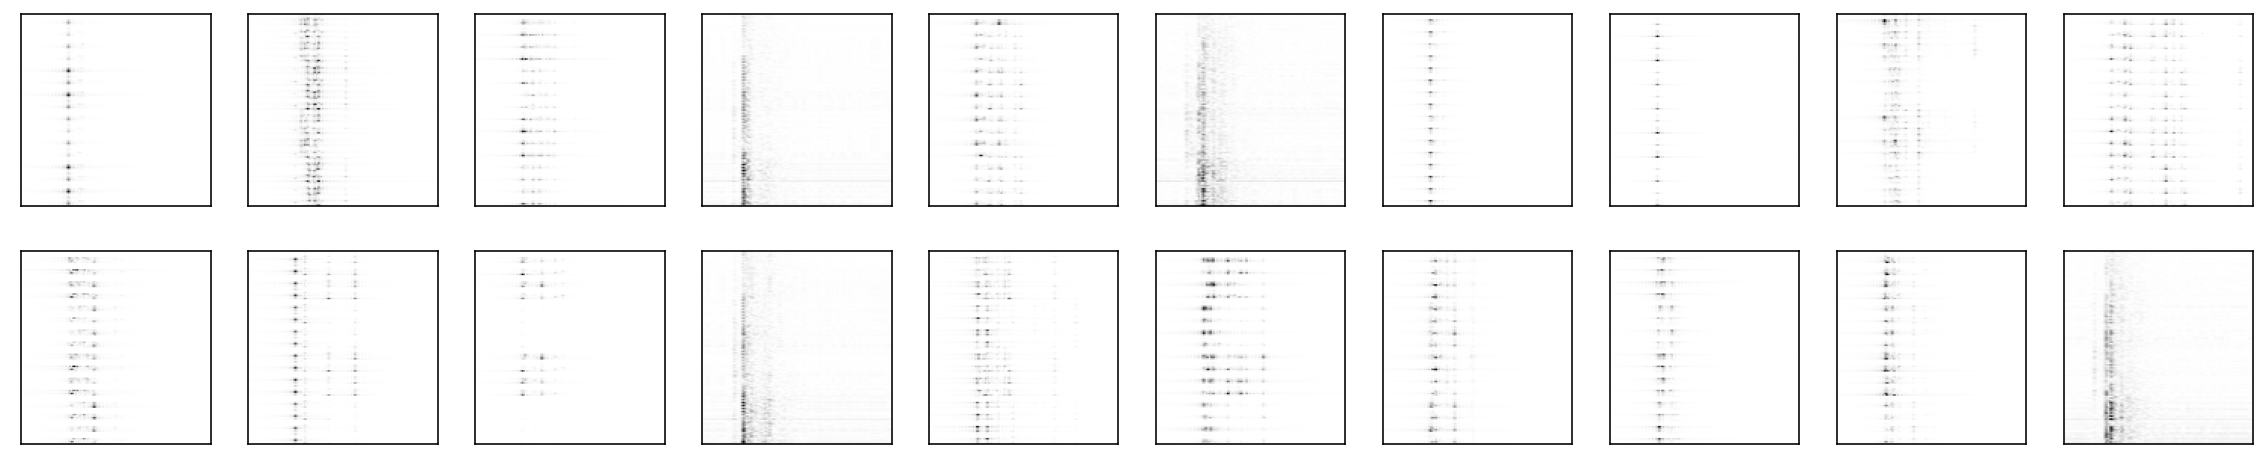

In [4]:
showImg(x_test,n=20,COL=10)

(16, 126, 8, 2)


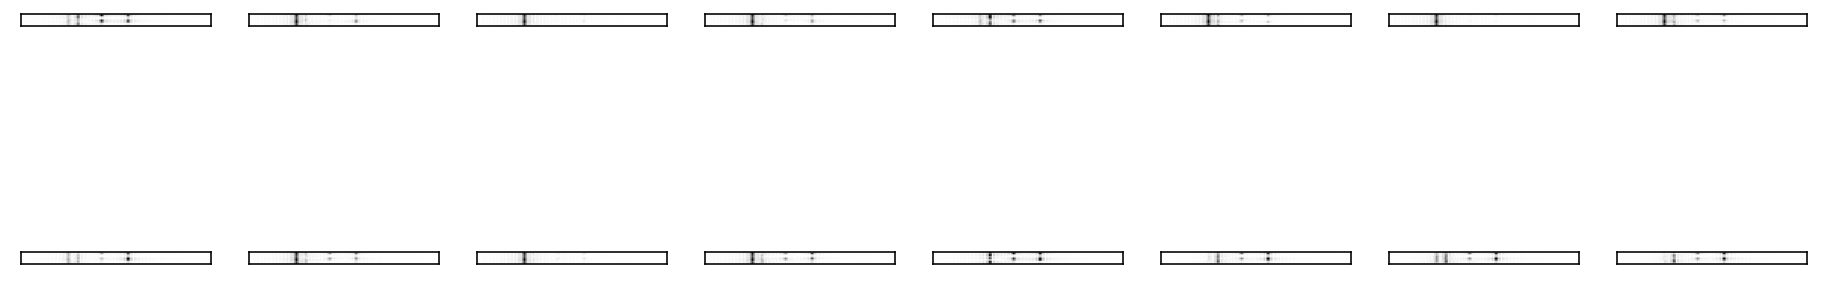

In [19]:
test_reshape=np.reshape(x_test,(-1,126,8,16,2)).transpose((0,3,1,2,4))[11]
print(test_reshape.shape)
showImg(test_reshape,n=16,COL=8)

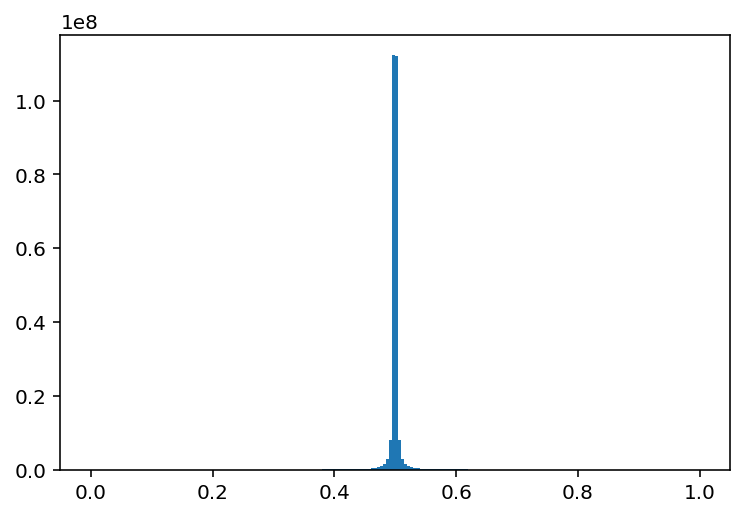

In [6]:
plt.hist(x_train.flatten(),200)
plt.show()

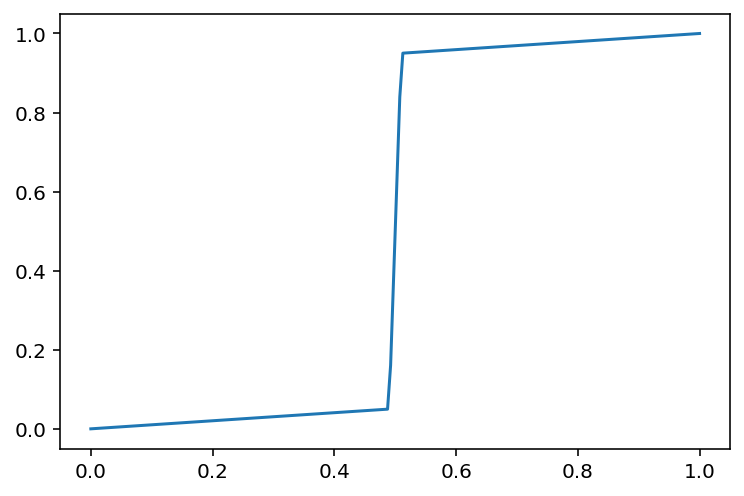

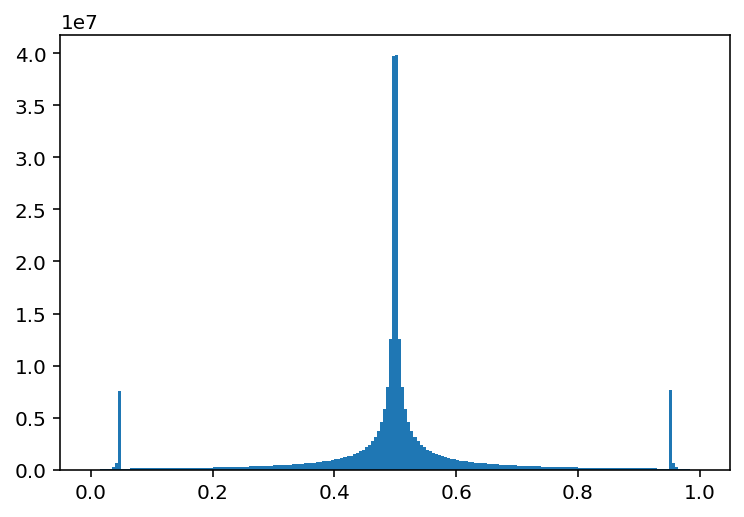

In [32]:
left_border=0.49
right_border=0.51
mid_k=45
def y_mid(x):
    return mid_k*(x-0.5)+0.5

lr_k=y_mid(left_border)/left_border
def y_left(x):
    return lr_k*x

right_b=y_mid(right_border)-lr_k*right_border
def y_right(x):
    return lr_k*x+right_b

def linearMapping(x):
    return np.select([x>=right_border, x>=left_border, x<left_border],
                     [y_right(x),      y_mid(x),       y_left(x)])

x_map = np.linspace(0,1,200)
y_map = linearMapping(x_map)
plt.plot(x_map,y_map)
plt.show()

plt.hist(linearMapping(x_train).flatten(),200)
plt.show()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input (InputLayer)      [(None, 512)]        0                                            
__________________________________________________________________________________________________
deuantization_layer_1 (Deuantiz None                 0           decoder_input[0][0]              
__________________________________________________________________________________________________
tf.reshape (TFOpLambda)         (None, 128)          0           deuantization_layer_1[0][0]      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32256)        4161024     tf.reshape[0][0]                 
____________________________________________________________________________________________

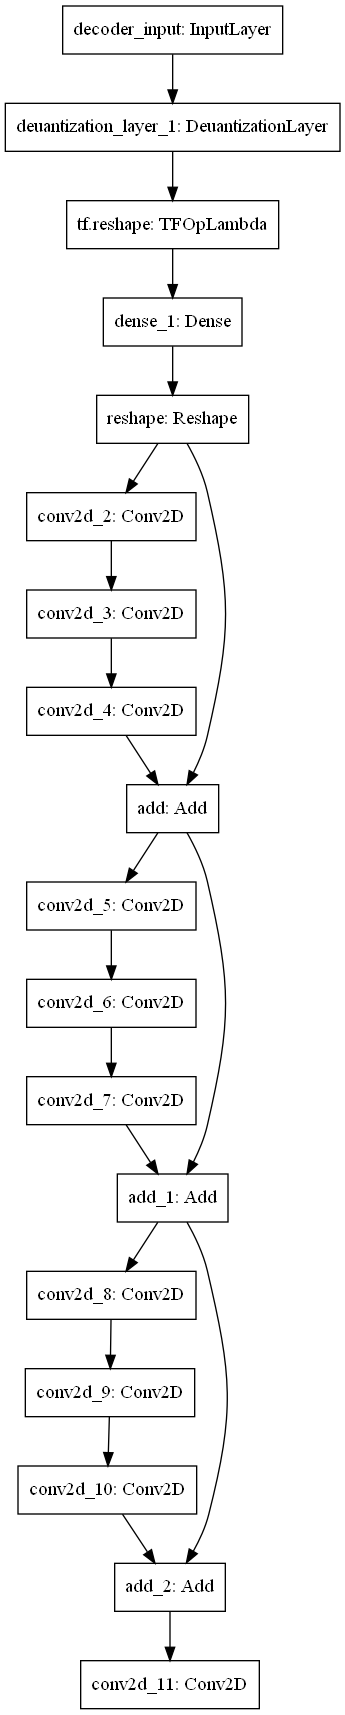

In [5]:
# load model
from Model_define_tf import get_custom_objects
encoder_address = 'Modelsave/20220114-235043S49.779/encoder.h5'
_custom_objects = get_custom_objects()  # load keywords of Custom layers
model_encoder = tf.keras.models.load_model(encoder_address, custom_objects=_custom_objects)
print(model_encoder.summary())
# plot_model(model_encoder,to_file="Modelsave/20220114-235043S49.779/encoder.png",show_shapes=True)
encode_feature = model_encoder.predict(x_train)
print(np.shape(encode_feature))


            4            3             2
-1.484e+05 x + 4.25e+05 x - 4.099e+05 x + 1.368e+05 x - 3322


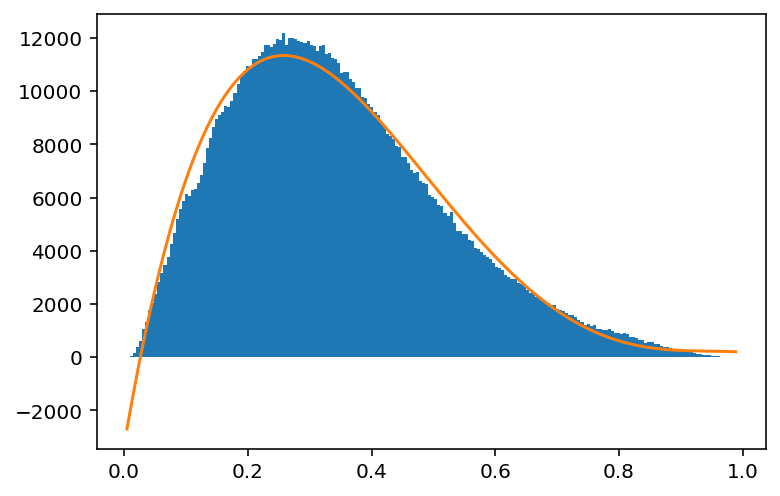

In [14]:
count, bins, ignored = plt.hist(encode_feature.flatten(), 200)
mid=list()
for i in range(1,len(bins)):
    mid.append((bins[i-1]+bins[i])/2)

pfit = np.polyfit(mid , count , 4)
y_fun = np.poly1d(pfit)
print(y_fun)
plt.plot(bins , y_fun(bins))
plt.show()

            4             3             2
-5.974e+05 x + 1.708e+06 x - 1.645e+06 x + 5.49e+05 x - 1.343e+04


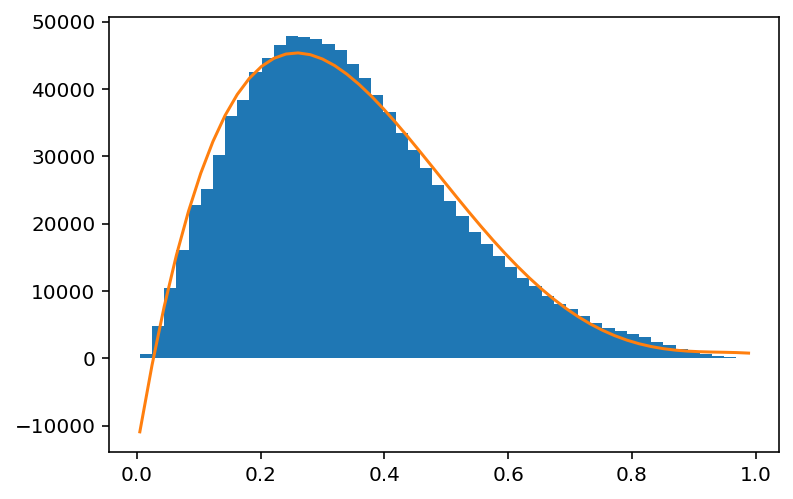

In [52]:
count, bins, ignored = plt.hist(encode_feature.flatten(), 50)
mid=list()
for i in range(1,len(bins)):
    mid.append((bins[i-1]+bins[i])/2)

pfit = np.polyfit(mid , count , 4)
y_fun = np.poly1d(pfit)
print(y_fun)
plt.plot(bins , y_fun(bins))
plt.show()

In [49]:
x_train

array([[[[0.49985054, 0.49932978],
         [0.5013558 , 0.49720144],
         [0.4994242 , 0.5002776 ],
         ...,
         [0.5001046 , 0.5001619 ],
         [0.50004566, 0.50013256],
         [0.4999622 , 0.50009465]],

        [[0.5010206 , 0.49985334],
         [0.506361  , 0.5039282 ],
         [0.49972892, 0.49894324],
         ...,
         [0.4999233 , 0.49980667],
         [0.49999985, 0.49994966],
         [0.50002503, 0.49997148]],

        [[0.50015676, 0.49986786],
         [0.49975628, 0.5009787 ],
         [0.4999217 , 0.49995098],
         ...,
         [0.500121  , 0.500193  ],
         [0.4999962 , 0.5001536 ],
         [0.49992523, 0.50008345]],

        ...,

        [[0.49998757, 0.49982688],
         [0.50032544, 0.49957904],
         [0.4998627 , 0.5000517 ],
         ...,
         [0.5000532 , 0.5000492 ],
         [0.5000202 , 0.50004834],
         [0.49998823, 0.50003666]],

        [[0.50036   , 0.49997574],
         [0.50201714, 0.50136614],
         [0.

        5         4         3         2
-5.905 x + 21.13 x - 27.18 x + 13.61 x - 0.6608 x


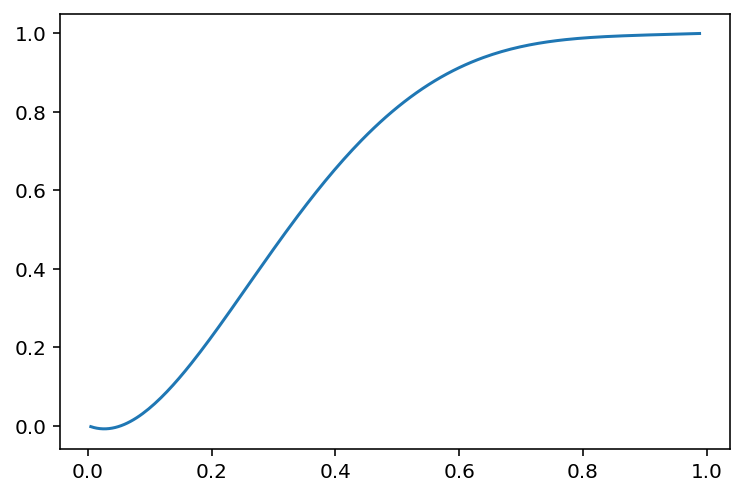

In [15]:
from sympy import symbols,integrate,Poly
x = symbols('x')

#numpy多项式转sympy表达式
exp=0
for i in range(len(pfit)):
    exp+=pfit[-i-1]*x**i

#求不定积分
i_expr=integrate(exp,x)

#sympy表达式转numpy多项式
p = Poly(i_expr, x)
coeffs=p.coeffs()
coeffs.append(0)#令常数项C=0
p_n=np.poly1d(coeffs)

#归一化
p_norm=p_n/p_n(1)

print(p_norm)
plt.plot(bins , p_norm(bins))
plt.show()

In [16]:
np.array(coeffs)/p_n(1)

array([-5.90465083523526, 21.1349180203538, -27.1796626871765,
       13.6101745534480, -0.660779051390061, 0], dtype=object)

In [17]:
encode_feature_flatten=encode_feature.flatten()
print(encode_feature_flatten)
encode_feature_mapped=p_n(encode_feature_flatten).astype(np.float32)
print(encode_feature_mapped)

[0.26222062 0.30596626 0.51988447 ... 0.3855583  0.20470986 0.45956144]
[1835.2787 2326.4568 4200.166  ... 3153.6396 1190.87   3792.223 ]


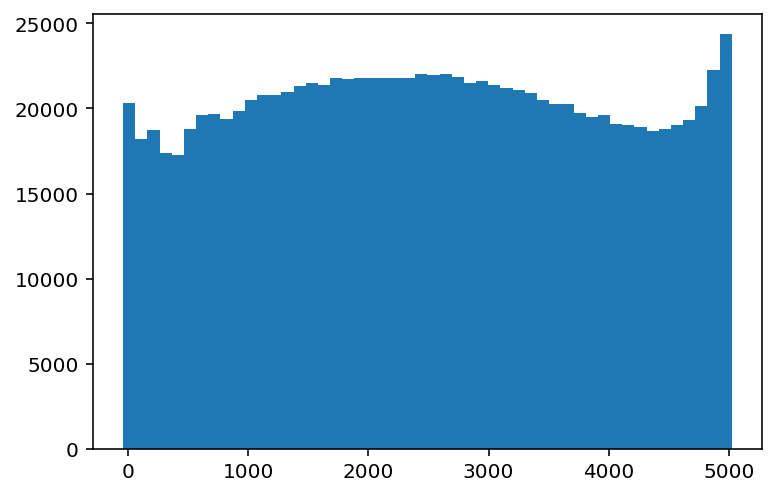

In [18]:
plt.hist(encode_feature_mapped, 50)
plt.show()

In [57]:
print(x_train.shape)

(8000, 126, 128, 2)


In [7]:
#添加高斯噪声
def gaussian_noise(img,mean,sigma):
    '''
    此函数将产生高斯噪声加到图片上
    :param img:原图
    :param mean:均值
    :param sigma:标准差
    :return:噪声处理后的图片
    '''

    # img = img/255  #图片灰度标准化

    noise = np.random.normal(mean, sigma, img.shape) #产生高斯噪声
    # print(noise)
    # 将噪声和图片叠加
    gaussian_out = img + noise
    # 将超过 1 的置 1，低于 0 的置 0
    gaussian_out = np.clip(gaussian_out, 0, 1)
    # 将图片灰度范围的恢复为 0-255
    # gaussian_out = np.uint8(gaussian_out*255)
    # 将噪声范围搞为 0-255
    # noise = np.uint8(noise*255)
    return gaussian_out# 这里也会返回噪声，注意返回值

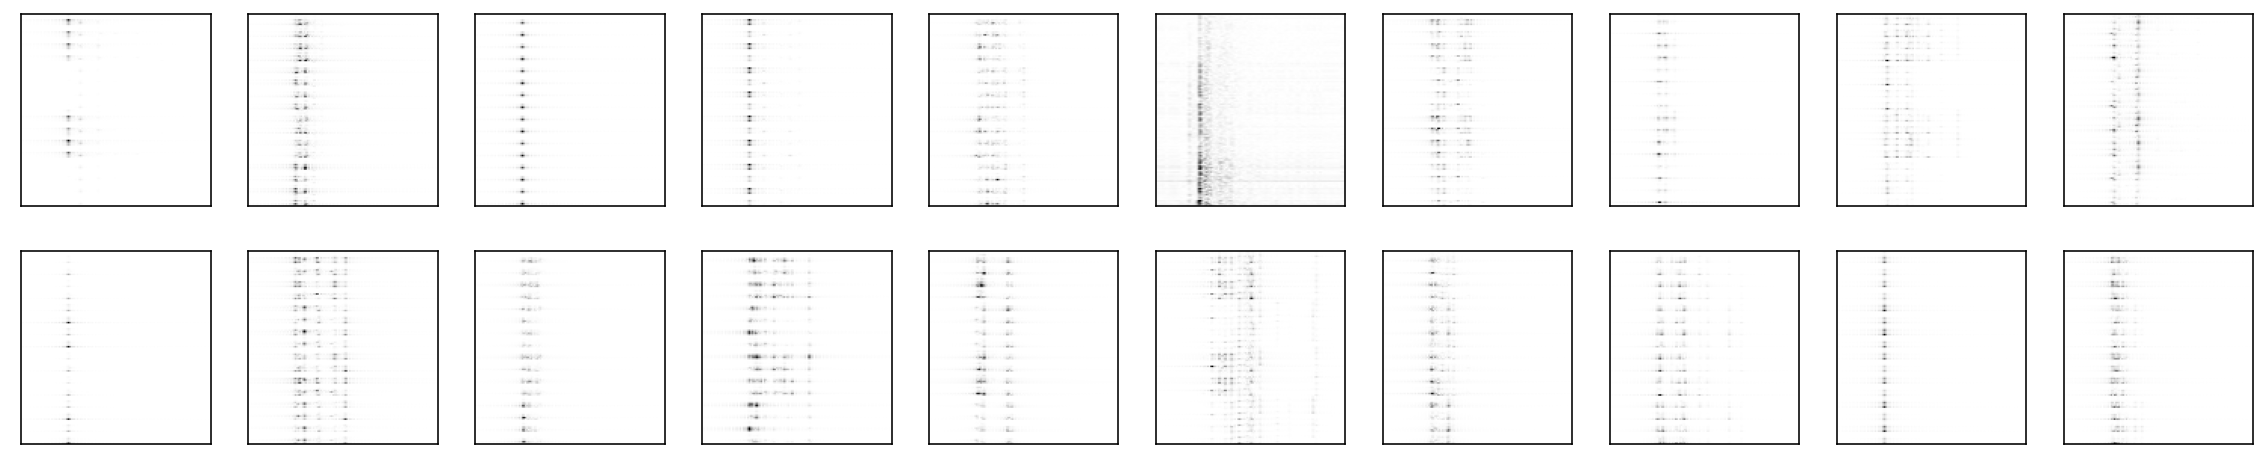

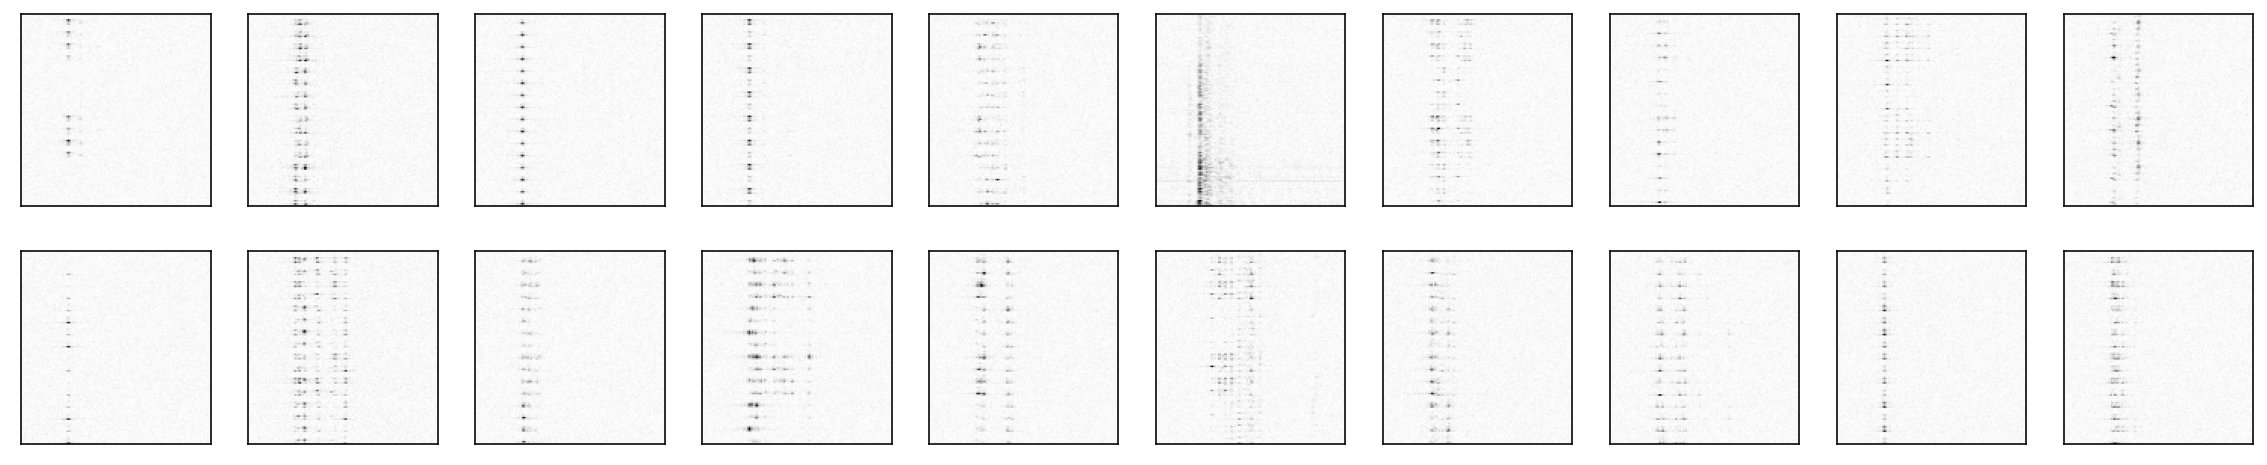

In [8]:
x_train_noise=gaussian_noise(x_train,0,0.01)
showImg(x_train,n=20,COL=10)
showImg(x_train_noise,n=20,COL=10)

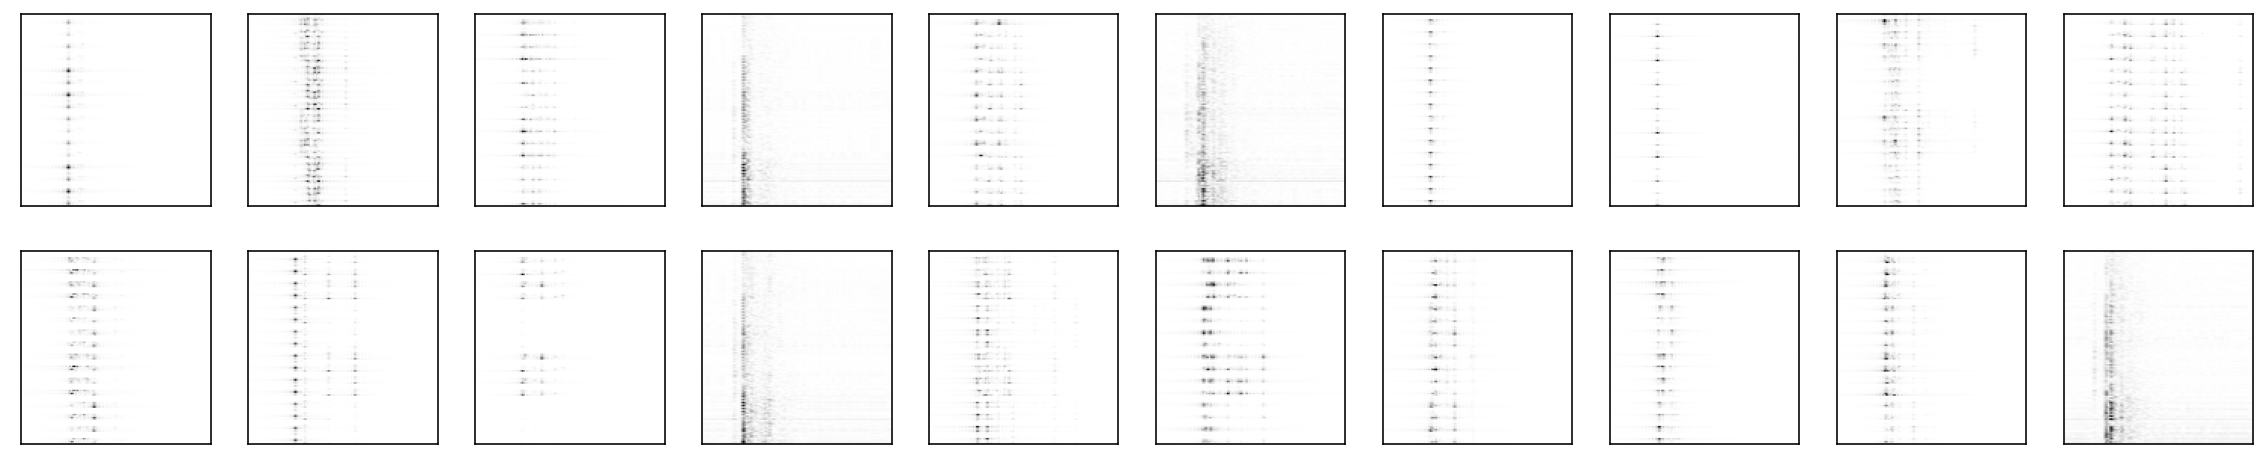

In [6]:
x_test=tf.convert_to_tensor(x_test)
showImg_t(x_test,n=20,COL=10)

In [8]:
half_point=x_test.shape[1]//2
x_lf=x_test[:,:half_point,:,:]
x_hf=x_test[:,half_point:,:,:]
x_exd=tf.concat([x_lf,x_hf],3)
x_exd=tf.expand_dims(x_exd,-1)
print(x_lf.shape)
print(x_hf.shape)
print(x_exd.shape)


(2000, 63, 128, 2)
(2000, 63, 128, 2)
(2000, 63, 128, 4, 1)


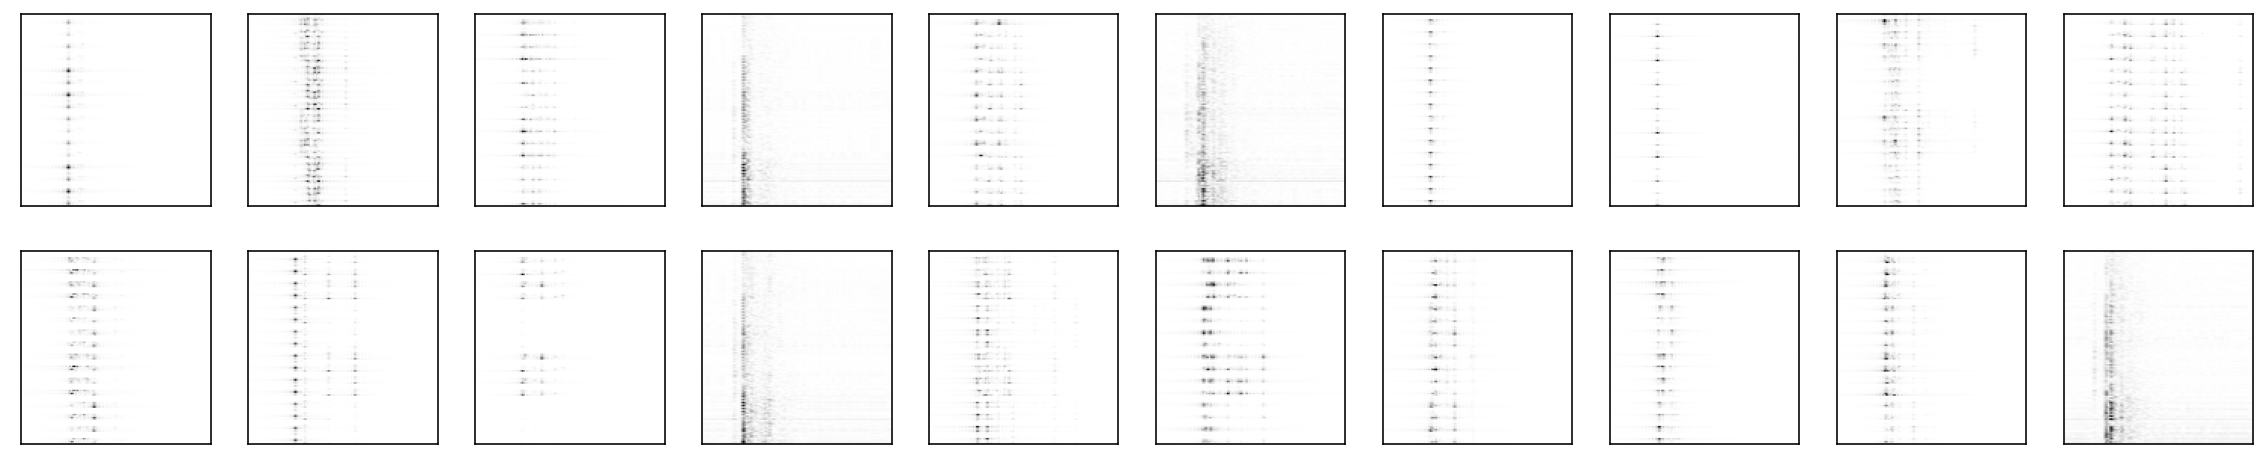

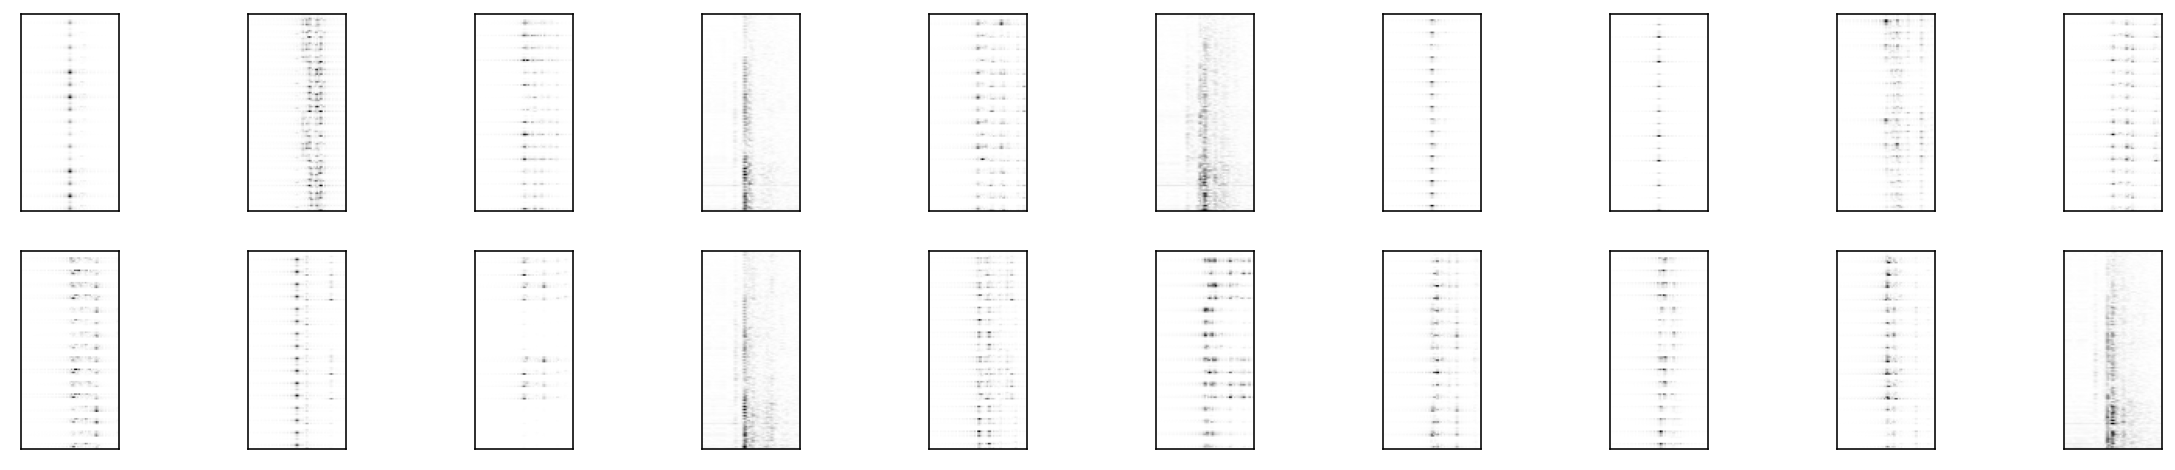

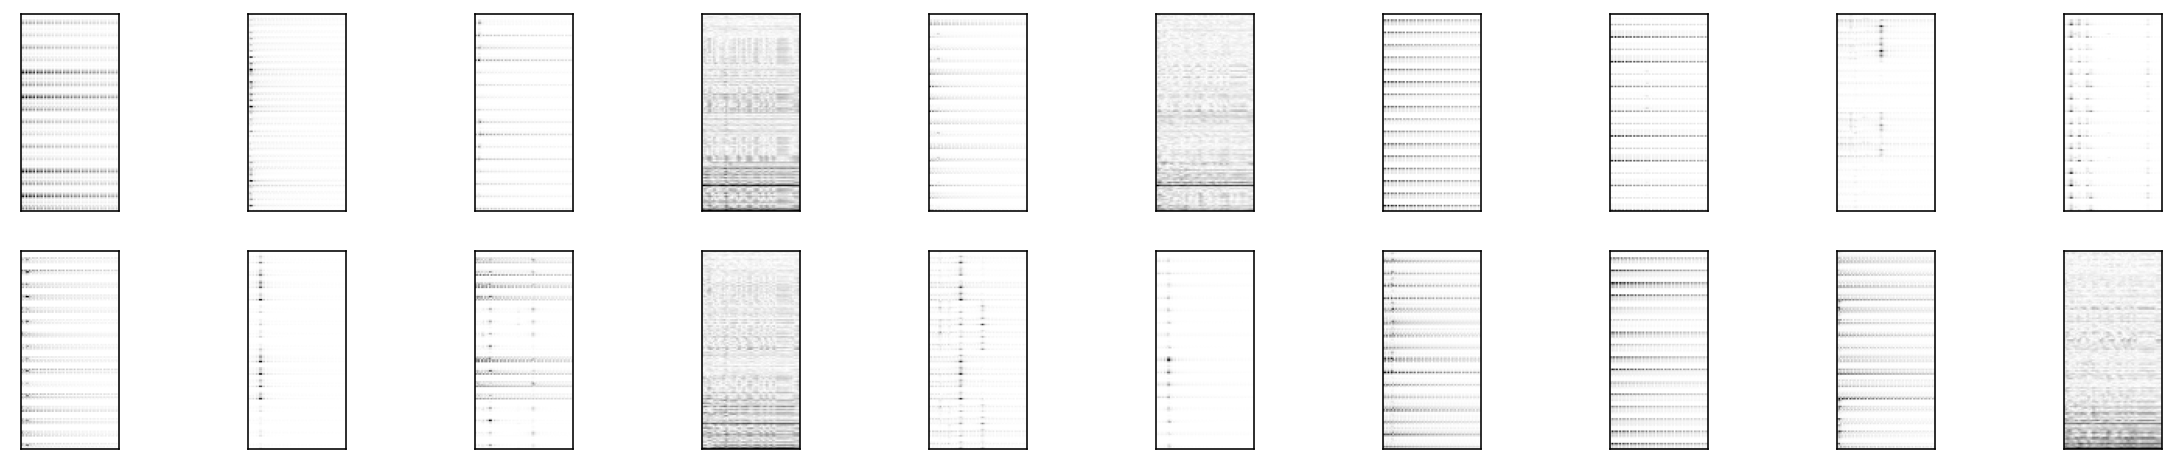

In [29]:
showImg_t(x_test[:,:,:,:],n=20,COL=10)
showImg_t(x_test[:,:63,:,:],n=20,COL=10)
showImg_t(x_test[:,63:,:,:],n=20,COL=10)

In [6]:
from tensorflow.keras import layers
def Num2Bit(Num, B):
    Num_ = Num.numpy()
    bit = (np.unpackbits(np.array(Num_, np.uint8), axis=1).reshape(-1, Num_.shape[1], 8)[:, :, 4:]).reshape(-1, Num_.shape[1] * B)
    bit.astype(np.float32)
    return tf.convert_to_tensor(bit, dtype=tf.float32)


def Bit2Num(Bit, B):
    Bit_ = Bit.numpy()
    Bit_.astype(np.float32)
    Bit_ = np.reshape(Bit_, [-1, int(Bit_.shape[1] / B), B])
    num = np.zeros(shape=np.shape(Bit_[:, :, 1]))
    for i in range(B):
        num = num + Bit_[:, :, i] * 2 ** (B - 1 - i)
    return tf.cast(num, dtype=tf.float32)


@tf.custom_gradient
def QuantizationOp(x, B):
    step = tf.cast((2 ** B), dtype=tf.float32)
    result = tf.cast((tf.round(x * step - 0.5)), dtype=tf.float32)
    result = tf.py_function(func=Num2Bit, inp=[result, B], Tout=tf.float32)

    def custom_grad(dy):
        grad = dy
        return (grad, grad)

    return result, custom_grad


class QuantizationLayer(layers.Layer):
    def __init__(self, B,**kwargs):
        self.B = B
        super(QuantizationLayer, self).__init__()

    def call(self, x):
        return QuantizationOp(x, self.B)

    def get_config(self):
        # Implement get_config to enable serialization. This is optional.
        base_config = super(QuantizationLayer, self).get_config()
        base_config['B'] = self.B
        return base_config


@tf.custom_gradient
def DequantizationOp(x, B):
    x = tf.py_function(func=Bit2Num, inp=[x, B], Tout=tf.float32)
    step = tf.cast((2 ** B), dtype=tf.float32)
    result = tf.cast((x + 0.5) / step, dtype=tf.float32)

    def custom_grad(dy):
        grad = dy * 1
        return (grad, grad)

    return result, custom_grad


class DeuantizationLayer(layers.Layer):
    def __init__(self, B,**kwargs):
        self.B = B
        super(DeuantizationLayer, self).__init__()

    def call(self, x):
        return DequantizationOp(x, self.B)

    def get_config(self):
        base_config = super(DeuantizationLayer, self).get_config()
        base_config['B'] = self.B
        return base_config

In [39]:
B = 4
x = layers.Flatten()(tf.random.uniform([1,128],0,1))
print(x)
# x = layers.Dense(units=int(feedback_bits//B), activation='sigmoid')(x)
# print(x.shape)
encoder_output = QuantizationLayer(B)(x)
# print(encoder_output.shape)
decoder_input = DeuantizationLayer(B)(encoder_output)
print(decoder_input)
# x = tf.reshape(decoder_input, (-1, int(feedback_bits//B)))
# print(x)
# x = layers.Dense(128, activation='sigmoid')(x)


tf.Tensor(
[[0.22557986 0.14776313 0.43140614 0.9440609  0.46728206 0.551836
  0.9822056  0.8583821  0.01118624 0.85110843 0.27524483 0.92128205
  0.7462512  0.7533424  0.5349847  0.62136304 0.9706354  0.23044336
  0.5891154  0.00187361 0.34351218 0.02543402 0.11566627 0.16866946
  0.9575652  0.6016674  0.8177054  0.14817846 0.99010694 0.07925498
  0.43817973 0.26444793 0.01541567 0.8974143  0.3111168  0.7974185
  0.2664528  0.6529696  0.11395645 0.11522317 0.9572393  0.8565196
  0.5511433  0.6783073  0.79088104 0.1389364  0.6708889  0.9834329
  0.18179381 0.4394096  0.37710297 0.1587584  0.47506797 0.6058228
  0.391536   0.36656106 0.05661976 0.21149337 0.04525232 0.1568042
  0.6503966  0.12033272 0.2232337  0.04033446 0.94462264 0.6570287
  0.23016405 0.81665206 0.91563165 0.6023152  0.6732708  0.05914497
  0.7256279  0.52905965 0.74902153 0.8828547  0.00350165 0.03995371
  0.79530096 0.11624408 0.9984567  0.17980218 0.7552421  0.6667248
  0.635376   0.81010914 0.12638736 0.9260154  

In [41]:
#导入相关包
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

#整个网络的维度变化为：784->256->2->256->784
batch_size = 100
#原始输入维度，28*28=784
original_dim = 784
#编码后的code的维度
latent_dim = 2
#中间隐藏层的维度
intermediate_dim = 256
#迭代50次
epochs = 50
#初始化时的标准差
epsilon_std = 1.0

#编码器的结构
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
# mean vector
z_mean = Dense(latent_dim)(h)
# standard deviation vector
z_log_var = Dense(latent_dim)(h)

#使用均值变量（mean vector）和标准差变量（standard deviation vector）合成隐变量
def sampling(args):
    z_mean, z_log_var = args
    #使用标准正态分布初始化
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,stddev=epsilon_std)
    #合成公式
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
#z即为所要求得的隐含变量
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
# 解码器的结构
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
#x_decoded_mean 即为解码器输出的结果
x_decoded_mean = decoder_mean(h_decoded)


# Custom loss layer
#自定义损失层，损失包含两个部分：图片的重构误差（交叉熵损失）以及隐变量与单位高斯分割之间的差异（KL-散度KL-Divergence Loss）。
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)#Square Loss
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)#KL-Divergence Loss
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

#将损失层加入网络
y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 784)]        0           []                               
                                                                                                  
 dense_33 (Dense)               (None, 256)          200960      ['input_1[0][0]']                
                                                                                                  
 dense_34 (Dense)               (None, 2)            514         ['dense_33[0][0]']               
                                                                                                  
 dense_35 (Dense)               (None, 2)            514         ['dense_33[0][0]']               
                                                                                              

In [42]:
# train the VAE on MNIST digits
#使用MNIST数据集进行训练
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#图像数据归一化
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)

#将图像数据转换为784维的向量
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)

11501568/11490434 [==============================] - 10s 1us/step
(60000, 28, 28)
(60000, 784)


In [43]:
#模型训练设置
vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

Epoch 1/50


TypeError: in user code:

    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 809, in train_step
        loss = self.compiled_loss(
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 239, in __call__
        self._loss_metric.update_state(
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\metrics_utils.py", line 73, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics.py", line 177, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\metrics.py", line 467, in update_state  **
        update_total_op = self.total.assign_add(value_sum)
    File "C:\Users\gaoweifan\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\keras_tensor.py", line 255, in __array__
        raise TypeError(

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='tf.math.reduce_sum_2/Sum:0', description="created by layer 'tf.math.reduce_sum_2'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.
